In [4]:
import sqlalchemy as sql
import pandas as pd
import glob
from os import path, sep
import numpy as np
import matplotlib.pyplot as plt

In [5]:
server = "thesis.ca6j6heoraog.eu-central-1.rds.amazonaws.com"
engine = sql.create_engine(f"mysql+pymysql://admin:FphvsYQek4@{server}/thesis_db")


In [6]:
con = engine.connect()

In [96]:
query_text = """
select data_ordinal, 
	a_value, 
    group_concat(b_value ORDER BY event_start_time) b_values,
    group_concat(
		cast( 100*(
			event_end_time-event_start_time)/(a_end_time-a_start_time) 
            as decimal(4,2) 
            ) ORDER BY event_start_time
		) p

from (
select a.data_ordinal, a.start_time a_start_time, a.end_time a_end_time, greatest(a.start_time,b.start_time) event_start_time, least(a.end_time, b.end_time) event_end_time, a.data_time_diff a_value, b.data_time_diff b_value
from 
( select data_ordinal, data_time-data_time_diff start_time, data_time end_time, data_time_diff
from raw_interval_data
where participant_id = 137
and series_type_id= 2 ) a
inner join
(select data_time-data_time_diff start_time, data_time end_time, data_time_diff
from raw_interval_data
where participant_id = 138
and series_type_id = 2 ) b
on (a.start_time <= b.start_time and a.end_time >= b.start_time or a.start_time <= b.end_time and a.end_time >= b.end_time)
) c
group by data_ordinal
"""

In [97]:
df = pd.read_sql(query_text, con)

/home/siegman/miniconda3/lib/python3.7/site-packages/pymysql/cursors.py:170: Warning: (1264, "Out of range value for column '(null)' at row 1")
  result = self._query(query)


In [98]:
df

,data_ordinal,a_value,b_values,p
0,1,0.882,0.79800,70.29
1,2,0.894,"0.79800,0.79400","19.91,80.09"
2,3,0.888,"0.79400,0.82600","8.78,91.22"
3,4,0.904,"0.82600,0.83000,0.79400","1.77,91.81,6.42"
4,5,0.928,"0.79400,0.75400","79.31,20.69"
...,...,...,...,...
264,274,0.828,"0.73800,0.76800","76.81,23.19"
265,275,0.772,"0.76800,0.81400","74.61,25.39"
266,276,0.820,"0.81400,0.83600","75.37,24.63"
267,277,0.744,"0.83600,0.79400","85.22,14.78"


In [99]:
df['b_value_list'] = df.b_values.map(lambda v: [float(x) for x in v.split(',')])
df['p_value_list'] = df.p.map(lambda v: [float(x) for x in v.split(',')])

df['b_value_list'] = df.b_value_list.map(lambda v: np.array(v))
df['p_value_list'] = df.p_value_list.map(lambda v: np.array(v))

df

,data_ordinal,a_value,b_values,p,b_value_list,p_value_list
0,1,0.882,0.79800,70.29,[0.798],[70.29]
1,2,0.894,"0.79800,0.79400","19.91,80.09","[0.798, 0.794]","[19.91, 80.09]"
2,3,0.888,"0.79400,0.82600","8.78,91.22","[0.794, 0.826]","[8.78, 91.22]"
3,4,0.904,"0.82600,0.83000,0.79400","1.77,91.81,6.42","[0.826, 0.83, 0.794]","[1.77, 91.81, 6.42]"
4,5,0.928,"0.79400,0.75400","79.31,20.69","[0.794, 0.754]","[79.31, 20.69]"
...,...,...,...,...,...,...
264,274,0.828,"0.73800,0.76800","76.81,23.19","[0.738, 0.768]","[76.81, 23.19]"
265,275,0.772,"0.76800,0.81400","74.61,25.39","[0.768, 0.814]","[74.61, 25.39]"
266,276,0.820,"0.81400,0.83600","75.37,24.63","[0.814, 0.836]","[75.37, 24.63]"
267,277,0.744,"0.83600,0.79400","85.22,14.78","[0.836, 0.794]","[85.22, 14.78]"


In [100]:
#df.apply(lambda r: None if sum(r[5])< 99. else r, axis=1)
df = df[df.apply(lambda r: sum(r[5])>=99.,  axis=1)].copy()

In [101]:
df['b_mean'] = df.apply(lambda r: np.array(r[4]).dot(np.array(r[5]))*0.01,axis=1)
df

,data_ordinal,a_value,b_values,p,b_value_list,p_value_list,b_mean
1,2,0.894,"0.79800,0.79400","19.91,80.09","[0.798, 0.794]","[19.91, 80.09]",0.794796
2,3,0.888,"0.79400,0.82600","8.78,91.22","[0.794, 0.826]","[8.78, 91.22]",0.823190
3,4,0.904,"0.82600,0.83000,0.79400","1.77,91.81,6.42","[0.826, 0.83, 0.794]","[1.77, 91.81, 6.42]",0.827618
4,5,0.928,"0.79400,0.75400","79.31,20.69","[0.794, 0.754]","[79.31, 20.69]",0.785724
5,6,0.922,"0.75400,0.79800","60.95,39.05","[0.754, 0.798]","[60.95, 39.05]",0.771182
...,...,...,...,...,...,...,...
263,273,0.834,"0.79400,0.73800","87.77,12.23","[0.794, 0.738]","[87.77, 12.23]",0.787151
264,274,0.828,"0.73800,0.76800","76.81,23.19","[0.738, 0.768]","[76.81, 23.19]",0.744957
265,275,0.772,"0.76800,0.81400","74.61,25.39","[0.768, 0.814]","[74.61, 25.39]",0.779679
266,276,0.820,"0.81400,0.83600","75.37,24.63","[0.814, 0.836]","[75.37, 24.63]",0.819419


In [102]:
df['b_std'] = df.apply(lambda r: np.sqrt(r[5].dot((r[4]-r[6])**2)/100),axis=1)
df

,data_ordinal,a_value,b_values,p,b_value_list,p_value_list,b_mean,b_std
1,2,0.894,"0.79800,0.79400","19.91,80.09","[0.798, 0.794]","[19.91, 80.09]",0.794796,0.001597
2,3,0.888,"0.79400,0.82600","8.78,91.22","[0.794, 0.826]","[8.78, 91.22]",0.823190,0.009056
3,4,0.904,"0.82600,0.83000,0.79400","1.77,91.81,6.42","[0.826, 0.83, 0.794]","[1.77, 91.81, 6.42]",0.827618,0.008821
4,5,0.928,"0.79400,0.75400","79.31,20.69","[0.794, 0.754]","[79.31, 20.69]",0.785724,0.016203
5,6,0.922,"0.75400,0.79800","60.95,39.05","[0.754, 0.798]","[60.95, 39.05]",0.771182,0.021466
...,...,...,...,...,...,...,...,...
263,273,0.834,"0.79400,0.73800","87.77,12.23","[0.794, 0.738]","[87.77, 12.23]",0.787151,0.018347
264,274,0.828,"0.73800,0.76800","76.81,23.19","[0.738, 0.768]","[76.81, 23.19]",0.744957,0.012661
265,275,0.772,"0.76800,0.81400","74.61,25.39","[0.768, 0.814]","[74.61, 25.39]",0.779679,0.020021
266,276,0.820,"0.81400,0.83600","75.37,24.63","[0.814, 0.836]","[75.37, 24.63]",0.819419,0.009479


<ErrorbarContainer object of 3 artists>

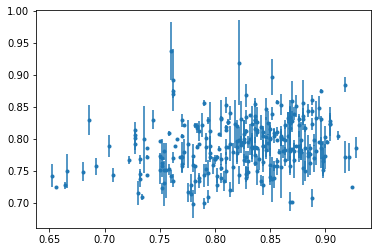

In [103]:
plt.errorbar(df.a_value.array, df.b_mean.array, df.b_std.array,fmt='.')

In [112]:
df1 = df.iloc[200:,:]

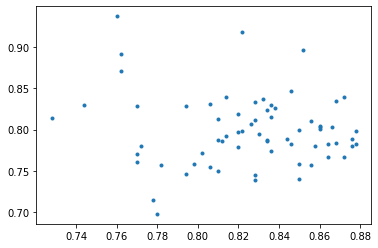

In [113]:
plt.plot(df1.a_value.to_numpy(), df1.b_mean.to_numpy(),'.')

In [114]:
np.corrcoef(df1.a_value.to_numpy(), df1.b_mean.to_numpy())

array([[ 1.        , -0.09461783],
       [-0.09461783,  1.        ]])

In [ ]:
import IPython.display  as ds
from importlib import reload

ds.display(ds.HTML(df.to_html()))

In [18]:
sum(df.b_std>0.03)

13

In [39]:
df.apply(lambda v: None if v[7]<0.05 else v, axis=1).dropna()

,data_ordinal,a_value,b_values,p,b_value_list,p_value_list,b_mean,b_std
0,1.0,0.684,0.61200,73.68,[0.612],[73.68],0.450922,0.138265
433,439.0,0.682,0.67800,80.65,[0.678],[80.65],0.546807,0.117818


In [40]:
max(df.data_ordinal)

439

In [41]:
df.iloc[:3,:]

,data_ordinal,a_value,b_values,p,b_value_list,p_value_list,b_mean,b_std
0,1,0.684,0.61200,73.68,[0.612],[73.68],0.450922,0.138265
1,2,0.702,"0.61200,0.60600","15.38,84.62","[0.612, 0.606]","[15.38, 84.62]",0.606923,0.002165
2,3,0.702,"0.60600,0.61600,0.63200","1.71,87.75,10.54","[0.606, 0.616, 0.632]","[1.71, 87.75, 10.54]",0.617515,0.005138
